In [1]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.operation import Operation

from tqdm.notebook import tqdm

In [2]:
# hyper parameters
epoch = 100

# the number of n, exclude the additional ancilla |1> state
_n_qubits = 3 # used as index, note: also used in Uf definition

In [3]:
# Uf(x) definition
from pennylane.operation import Operation
# qml functions

def hadamard_op(n_qubits):
    # register 1
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        
        
        
# return observable
def observable_op(n_qubits, observable):
    _observable = observable(wires=0)
    for i in range(1, n_qubits):
        _observable = qml.operation.Tensor(_observable, observable(wires=i))
    return _observable



def cnot_op(n_qubits):
    # register 1
    for i in range(n_qubits):
        qml.CNOT([i, n_qubits])
        
        

def ancilla_qubit_op_(op_list, wire):
    # register 2
    for gate_op in op_list:
        gate_op(wire)
        
        
        
# balanced
class balancedGate(Operation):
    grad_recipe = None
    num_params = 1
    num_wires = _n_qubits+1
    # In the future, the abstract method par_domain will be removed
    par_domain = "R" 
        
    @staticmethod
    def decomposition(num_qubits):
        cnot_op(num_qubits)



# constant
class constantGate(Operation):
    grad_recipe = None
    num_params = 1
    num_wires = 1
    # In the future, the abstract method par_domain will be removed
    par_domain = "R" 
    
    @staticmethod
    def decomposition(boolean, wire):
        # f(x) = 1
        if boolean:
            qml.PauliX(wire)
        else: # f(x) = 0
            qml.Identity(wire)
            


In [4]:
# return quantum circuit that solves the problem
# containing trainable parameters for layer after Uf (user defined) 

# exclude the extra qubit
# total qubit count is _n_qubit+1
def circuit_init(n_qubits=1, _oracle=None, _oracle_args=None, measure=None, measure_args=None):
    
    dev = qml.device("default.qubit", wires=n_qubits+1)
    
    @qml.qnode(dev, diff_method="parameter-shift")
    def circuit(_ancilla_qubit_op_list=[qml.PauliX],
                state_processing=None, state_processing_vars=None, re_apply=True,
                oracle=_oracle, oracle_args=_oracle_args, 
                var_gate=None, var_gate_args=None,
                   _measure_args=measure_args):

        # register 2
        ancilla_qubit_op_(_ancilla_qubit_op_list, n_qubits)
        # register 1
        hadamard_op(n_qubits+1)

        if state_processing is not None:
            state_processing(state_processing_vars)
        
        oracle(*oracle_args)
        
        if state_processing is not None and re_apply:
            state_processing(state_processing_vars)
            
        var_gate(*var_gate_args)
        
        return measure(*_measure_args)
    
    return circuit

In [5]:
# custom (trainable) gate definition

# based on text book, decomposit arbitrary quantum gate to ry rz 
class universal_gate(Operation):
    grad_recipe = None
    num_params = 1
    num_wires = _n_qubits
    # In the future, the abstract method par_domain will be removed
    par_domain = "R" 
    
    @staticmethod
    def decomposition(num_qubits, params):
        for i in range(num_qubits):
            qml.RZ(params[i*3+2], i)
            qml.RY(params[i*3+1], i)
            qml.RZ(params[i*3], i)

In [6]:
# cost function

def cost(trg, _circuit, _universal_gate, params, _state_processing=None, _state_processing_vars=None, measure_args=[range(_n_qubits)], wire=0):
    return abs(trg - _circuit(state_processing=_state_processing, 
                              state_processing_vars=_state_processing_vars,
                              var_gate=_universal_gate.decomposition, var_gate_args=[_n_qubits, params], 
                              _measure_args=measure_args)[wire])


Fixed Uf -- trainging parameters
=======================================

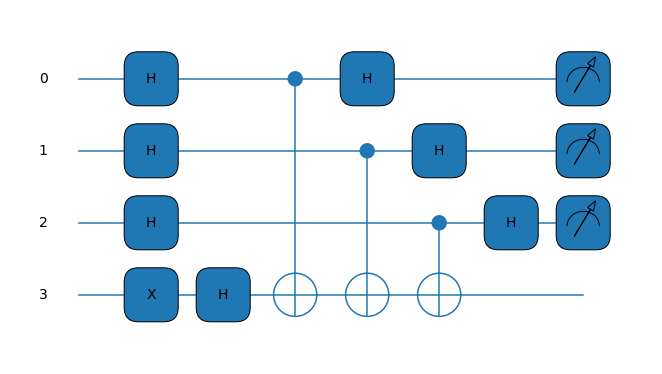

tensor([0., 0., 0., 0., 0., 0., 0., 1.], requires_grad=True)

In [7]:
# circuit instance

trg_balanced = 0
trg_constant = 1

circuit = circuit_init(n_qubits=_n_qubits, 
                        _oracle=balancedGate.decomposition,
                        _oracle_args=[_n_qubits],
                        # oracle=constantGate.decomposition,
                        # oracle_args=[True, _n_qubits],
                        measure=qml.probs, 
                        measure_args=[range(_n_qubits)]
                        # measure=qml.expval, 
                        #  measure_args=[observable_op(_n_qubits, qml.Identity)]
                        )

fig, ax = qml.draw_mpl(circuit, decimals=2)(var_gate=hadamard_op, var_gate_args=[_n_qubits])
plt.show()
# fig, ax = qml.draw_mpl(circuit, decimals=2)(custom_gate.decomposition, [_n_qubits, init_params])
# plt.show()

circuit(var_gate=hadamard_op, var_gate_args=[_n_qubits])

In [8]:
# train the model

# weight initialization for quantum circuit
init_params = np.zeros(3*_n_qubits, requires_grad=True)

# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the initial parameter values
params = init_params

# set target
trg = trg_balanced

for i in range(epoch):
    # update the circuit parameters
    params = opt.step(cost, trg, circuit, universal_gate, params)[3]

    if (i + 1) % 10 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(trg, circuit, universal_gate, params)))

print("Optimized rotation angles: {}".format(params))
circuit(var_gate=universal_gate.decomposition, var_gate_args=[_n_qubits, params])

Cost after step    10:  0.0371688
Cost after step    20:  0.0175632
Cost after step    30:  0.0103704
Cost after step    40:  0.0069334
Cost after step    50:  0.0050121
Cost after step    60:  0.0038217
Cost after step    70:  0.0030286
Cost after step    80:  0.0024712
Cost after step    90:  0.0020628
Cost after step   100:  0.0017536
Optimized rotation angles: [ 0.         -0.86150089  0.          0.         -0.86150089  0.
  0.         -0.86150089  0.        ]


tensor([0.00175359, 0.01278824, 0.01278824, 0.09325945, 0.01278824,
        0.09325945, 0.09325945, 0.68010332], requires_grad=True)


Bruteforce -- training parameters
=======================================

In [12]:
import random
import itertools

# state processing before oracle
def state_processing_(wire_list):
    for i in wire_list:
        qml.PauliX(i)
        
        
# 256 samples for n_qubits=3
# return generator as a function (reusable)
def wire_selection(n_wire, seed=None, data_augument_constant=False):
    
    def generator_obj(_seed=seed, _n_wire=n_wire):
        if _seed is not None:
            random.seed(_seed)
        idx = range(_n_wire)

        if data_augument_constant:
            for i in range(200):
                yield ()
        for L in range(0, len(idx)+1):
            for subset in itertools.combinations(idx, L):
                yield subset

    return lambda: generator_obj()


In [13]:
# circuit instance

trg_balanced = 0
trg_constant = 1

# set target
trg = trg_balanced

circuit_bruteforce = circuit_init(n_qubits=_n_qubits, 
                        _oracle=balancedGate.decomposition,
                        _oracle_args=[_n_qubits],
                        # _oracle=constantGate.decomposition,
                        # _oracle_args=[False, _n_qubits],
                        measure=qml.probs, 
                        measure_args=[range(_n_qubits)]
                        )

In [14]:
# train the model

# weight initialization for quantum circuit
init_params = np.zeros(3* _n_qubits, requires_grad=True)

# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the initial parameter values
params = init_params

wire_selection_generator = wire_selection(_n_qubits, seed=1, data_augument_constant=True)

for i in range(epoch):
    for sample in wire_selection_generator():
        # update the circuit parameters
        params = opt.step(cost, trg, circuit_bruteforce, universal_gate, params, 
                          _state_processing=state_processing_, _state_processing_vars=sample)[3]
        
    if (i + 1) % 10 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(trg, circuit_bruteforce, universal_gate, params, 
                                                                  _state_processing=state_processing_, _state_processing_vars=sample)))

print("Optimized rotation angles: {}".format(params))
circuit_bruteforce(var_gate=universal_gate.decomposition, var_gate_args=[_n_qubits, params])

Cost after step    10:  0.0000158
Cost after step    20:  0.0000055
Cost after step    30:  0.0000030
Cost after step    40:  0.0000019
Cost after step    50:  0.0000014
Cost after step    60:  0.0000010
Cost after step    70:  0.0000008
Cost after step    80:  0.0000007
Cost after step    90:  0.0000006
Cost after step   100:  0.0000005
Optimized rotation angles: [ 0.         -1.39379496  0.          0.         -1.39379496  0.
  0.         -1.39379496  0.        ]


tensor([4.76735293e-07, 6.05497282e-05, 6.05497282e-05, 7.69036745e-03,
        6.05497282e-05, 7.69036745e-03, 7.69036745e-03, 9.76746772e-01], requires_grad=True)

In [15]:
idx = range(8)
def gene():
    for L in range(0, len(idx)+1):
        for subset in itertools.combinations(idx, L):
            yield subset
counter=0
for i in gene():
    counter+=1
print(counter)

256
